# Liner Regression Model Tutorial

***

## Introduction:

Since the early years of humanity, there has always been a desire to predict future outcomes before they happened. The Ancient Greeks used Oracles, or divine priestesses, to predict the future by listening to their supposed messages from the Gods. The Ancient Chinese would engrave messages on bones, mashup and heat the bones, and then use the priest to interpret the answers returned by divine entities. While their approaches may have been different, the goal was the same: **predict an outcome before it happened.**

As time went on, humanity developed and invented new fields of study related to mathematics and statistics. These topics would help scientist and mathematicians develop new ways to explore their world and devise more realistic means of prediction that were grounded in observations and data.

**However, all these models required data that could be measured and manipulated, something that was challenging to obtain before the advent of the computer.** Enter the age of the modern computer, and data went from a scarce asset to an overly abundant commodity that required new technologies to handle and analyzes.

The combination of a large amount of data & powerful computers that could compute more numbers in a few minutes than a single person could in their entire life, meant we could make models more accurate and dynamic than ever before. Soon, the field of machine learning would take off as individuals realized they could create computer programs that could learn from all of this data. New models were developed to handle different types of data and problems, and a repository of new techniques could be referenced to devise new solutions to old problems.

One of the models we will discuss in this series is the Linear Regression Model. **The Linear Regression Model attempts to model the relationship between two variables by fitting a linear equation (a line) to observed data**. In the model, one variable is considered to be an **explanatory variable** (X Variable), and the other is considered to be a **dependent variable** (Y Variable).

## Background:

In our example, we are going to try an model the relationships between two financial assets, the price of a single share of Exxon Mobile stock and the price of a barrel of oil. **The question we are trying to answer is, does the explanatory variable (Oil) do a good job at predicting the dependent variable (a single share of Exxon Mobile stock.)**

### Why a linear regression model?
There are so many models to choose from, why this one? Well there can be many reasons why we would choose a given model, but there were a few key reasons why a linear regression model is being selected for this example

> - We want to know whether one measurement variable is associated with another measurement variable.
> - We want to measure the strength of the association (r2).
> - We want an equation that describes the relationship and can be used to predict unknown values.

***
The linear model will take the following form:

$y = \beta_0 + \beta_1x$

Where each term represents:

- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x

## Step One: Import our libraries
To build our model, we will need some tools at our disposal to make the process as seamless as possible. We will not go through all the libraries but will take the time to explain a few.

1. **Pandas** - This will make grabbing and transforming the data quick.
2. **Sklearn** - We can leverage the built-in machine learning models they have.
3. **Scipy** - This will make interpreting our output much more comfortable.
4. **Matplotlib** - Visuals are critical to analysis, and this library will help us build those visuals.

In [1]:
#https://matplotlib.org/gallery/color/named_colors.html
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm
import math 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

%matplotlib inline

***
## Step Two: Load the Data
We want our data in a DataFrame as this will give it the proper structure need to analyze the data. Once we load the data into a DataFrame, we need an index so we will set that equal to our date column. Finally, it is good to check the data looks correct before moving on, so let us print out the first five rows using the `head()` method.

In [2]:
from domino.data_sources import DataSourceClient

# instantiate a client and fetch the datasource instance
ds = DataSourceClient().get_datasource("UX-QUALITY")

# res is a simple wrapper of the query result
res = ds.query("select * from RAW_OIL_PRICE")

# to_pandas() loads the result into a pandas dataframe
price_data = res.to_pandas()
price_data.head(10)


,DATE,EXON_PRICE,OIL_PRICE
0,2014-03-28,97.699997,106.64
1,2014-03-31,97.680000,105.95
2,2014-04-01,97.730003,105.70
3,2014-04-02,97.949997,103.37
4,2014-04-03,97.930000,104.88
5,2014-04-04,97.360001,106.41
6,2014-04-07,96.779999,104.89
7,2014-04-08,97.449997,105.83
8,2014-04-09,97.330002,107.39
9,2014-04-10,96.779999,107.10


In [3]:
# set the index equal to the date column & then drop the old date column
price_data.index = pd.to_datetime(price_data['DATE'])
price_data = price_data.drop(['DATE'], axis = 1)

# print the first five rows
price_data.head()

,EXON_PRICE,OIL_PRICE
DATE,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


***
## Step Three: Clean the data
The chances of getting a perfectly cleaned dataset that meets all of the requirements is slim to none, so to make this tutorial more realistic we will clean the data. Here is the checklist when it comes to cleaning the data:

> 1. Check the data types, to make sure they are correct. For example, it usually does not make sense for a number to be a string.
> 2. Make sure the column names are correct. Having the correct column names makes the process of selecting data easier.
> 3. Check for and drop/fill missing values. Dropping errors helps to control for errors when running.

In [4]:
# check the data types, in this case everything looks fine no changes need to be made.
price_data.dtypes

EXON_PRICE    float64
OIL_PRICE     float64
dtype: object

While looking at the data, we can see one of the columns is misspelled, so let us fix that by creating a dictionary object where the old name is the key, and the new name is the value for that key. Once we do that, we can call the `rename()` method on the DataFrame and pass through the `new_column_names` dictionary through the `columns` parameter.

In [5]:
# define the new name.
new_column_names = {'EXON_PRICE':'EXXON_PRICE'}

# rename the column
price_data = price_data.rename(columns = new_column_names)
price_data.head()

,EXXON_PRICE,OIL_PRICE
DATE,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


Missing values, they can be a problem because they can create errors when running calcs. The first thing is we should always check to see if there are any missing values. If we use the `.isna().any()` method on the DataFrame it will return each column with a boolean, where `True` means it has missing values and `False` means it does not have any missing values. Once, we know the data has missing values we can use the `dropna()` method to drop any rows that have a missing value.

In [6]:
# check for missing values
display(price_data.isna().any())

# drop any missing values
price_data = price_data.dropna()

# let's check to make sure they've all been removed.
price_data.isna().any()

EXXON_PRICE    False
OIL_PRICE      False
dtype: bool

EXXON_PRICE    False
OIL_PRICE      False
dtype: bool

***
## Section Four: Explore the Data
Okay, now that we have a clean dataset let us explore it a little. Again, this is a critical step as it helps us understand some of the following questions:

1. How is the data distributed?
2. Does there appear to be a relationship between the two variables?
3. Are there any outliers?
4. Is the data skewed?

By better understanding the answers to these questions we can validate whether we need to do further transformations or if we need to change the model we picked.

***
### Build a Scatter Plot
Scatter plots help us visualize the relationship between our data, so let us plot our data using the graph so we can explore the relationship. We need to define the x-coordinate and the y-coordinate, and then plot them using the `plot()` method. Now, we did a few formatting steps, so our graph comes out logically.

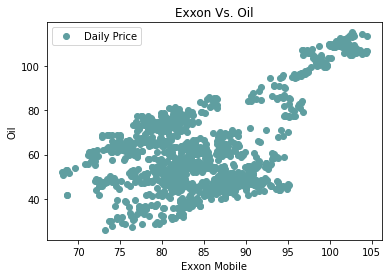

In [7]:
# define the x & y data.
x = price_data['EXXON_PRICE']
y = price_data['OIL_PRICE']

# create the scatter plot.
plt.plot(x, y, 'o', color ='cadetblue', label = 'Daily Price')

# make sure it's formatted.
plt.title("Exxon Vs. Oil")
plt.xlabel("Exxon Mobile")
plt.ylabel("Oil")
plt.legend()

plt.show()

***
### Measure the Correlation
At first glance, we can tell there is some relationship here because they seem to be moving in tandem. The relationship means if one goes up the other appears to go up as well and also tells us it appears to be a positive relationship because they both move up. However, if we would like to attach a number to this relationship so we can quantify it. Well, in this case, let us measure the correlation between the two variables. We will take the DataFrame and call the `corr()` method to return a DataFrame with the metrics.

In [8]:
# let's measure that correlation
price_data.corr()

,EXXON_PRICE,OIL_PRICE
EXXON_PRICE,1.00000,0.60132
OIL_PRICE,0.60132,1.00000


Okay, so there is a correlation and a strong one at that. Generally speaking, this is how we measure the strength of correlations.

 - Very strong relationship **(|r|>0.8 =>)**
 - Strong relationship **(0.6≤|r|)**
 - Moderate relationship **(0.4≤|r|)**
 - Weak relationship **(0.2≤|r|)**
 - Very weak relationship **(|r|)** 

***
### Create a Statistical Summary
Okay, so we see there is a correlation let us create a statistical summary to help describe the dataset. We will use the `describe()` method to output a DataFrame with all this info.

In [9]:
# let's take a look at a statistical summary.
price_data.describe()

,EXXON_PRICE,OIL_PRICE
count,1248.000000,1248.000000
mean,84.802796,61.935000
std,7.424687,19.288424
min,68.120003,26.010000
25%,80.190002,48.162500
50%,83.024998,57.120000
75%,88.529999,70.725000
max,104.379997,115.190000


Nothing stands out as a concern at this point, our range is healthy, and all the data falls within 3 Standard deviations of the mean. In other words, we do not seem to have any outliers that we need to worry with. They both have the same count so we look good there and we get a good idea of the min and max. Overall, we should be happy with the output.

***
### Checking for Outliers and Skewness
We do not want outliers, and we want to make sure our data does not have skew because this could impact results in specific models. The first thing we will do is a plot a histogram for each column of data. The data will help us get a good idea of the distribution. Once, we have done that we will do some hard measurements to validate our visuals.

array([[<AxesSubplot:title={'center':'EXXON_PRICE'}>,
        <AxesSubplot:title={'center':'OIL_PRICE'}>]], dtype=object)

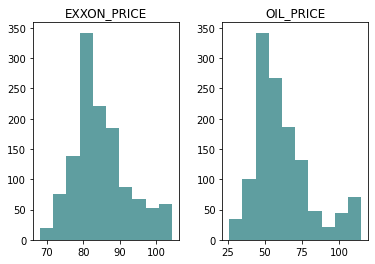

In [10]:
price_data.hist(grid = False, color = 'cadetblue')

Okay, so some of the data does appear to be skewed but not too much. However, we probably should verify this by taking some measurements. Two good metrics we can use are the kurtosis and skew, where kurtosis measure the height of our distribution and skew measures whether it is positively or negatively skewed. We will use the `scipy.stats` module to do the measurements.

In [11]:
# calculate the excess kurtosis using the fisher method. The alternative is Pearson which calculates regular kurtosis.
exxon_kurtosis = kurtosis(price_data['EXXON_PRICE'], fisher = True)
oil_kurtosis = kurtosis(price_data['OIL_PRICE'], fisher = True)

# calculate the skewness
exxon_skew = skew(price_data['EXXON_PRICE'])
oil_skew = skew(price_data['OIL_PRICE'])

display("Exxon Excess Kurtosis: {:.2}".format(exxon_kurtosis))  # this looks fine
display("Oil Excess Kurtosis: {:.2}".format(oil_kurtosis))      # this looks fine

display("Exxon Skew: {:.2}".format(exxon_skew))          # moderately skewed
display("Oil Skew: {:.2}".format(oil_skew))              # moderately skewed, it's a little high but we will accept it.

'Exxon Excess Kurtosis: 0.088'

'Oil Excess Kurtosis: 0.53'

'Exxon Skew: 0.66'

'Oil Skew: 1.0'

We can also perform a `kurtosistest()` and `skewtest()` on our data to test whether the data is normally distributed. With these two functions we test the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1) & the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution, respectively.

However, there is a **big caveat** to this.  As our dataset grows larger, the chances of us rejecting the null hypothesis increases even if there is only slight kurtosis or skew. In other words, even if our dataset is slightly non-normal, we will reject the null hypothesis. These results are unrealistic because the chances of us having a perfectly normal dataset are very very slim, so we have to take these results with a grain of salt.

In [12]:
# perform a kurtosis test
display('Exxon')
display(stats.kurtosistest(price_data['EXXON_PRICE']))
display('Oil')
display(stats.kurtosistest(price_data['OIL_PRICE']))

# perform a skew test
display('Exxon')
display(stats.skewtest(price_data['EXXON_PRICE']))
display('Oil')
display(stats.skewtest(price_data['OIL_PRICE']))

'Exxon'

KurtosistestResult(statistic=0.7185349375030217, pvalue=0.47242751383320714)

'Oil'

KurtosistestResult(statistic=3.193868719980946, pvalue=0.0014037993965471192)

'Exxon'

SkewtestResult(statistic=8.770169400598547, pvalue=1.7839768456341785e-18)

'Oil'

SkewtestResult(statistic=12.471137868018896, pvalue=1.0728306198159925e-35)

If we look at the results above, we will reject the null hypothesis 3 out of 4 times, even with the data being slightly skewed or having mild kurtosis. This is why we always need to visualize the data and calculate the metrics before running these test.

***

**Kurtosis**
- Any distribution with **kurtosis ≈3 (excess ≈0)** is called mesokurtic. This is a normal distribution
- Any distribution with **kurtosis <3 (excess kurtosis <0)** is called platykurtic. Tails are shorter and thinner, and often its central peak is lower and broader.
- Any distribution with **kurtosis >3 (excess kurtosis >0)** is called leptokurtic. Tails are longer and fatter, and often its central peak is higher and sharper.

***

**Skewness**
- If skewness is **less than −1 or greater than +1**, the distribution is highly skewed.
- If skewness is **between −1 and −½ or between +½ and +1**, the distribution is moderately skewed.
- If skewness is **between −½ and +½**, the distribution is approximately symmetric.

## Section Five: Build the Model
At this point, we feel comfortable moving forward other than the data being slightly skewed nothing else is stopping us from going with the linear regression model.

***
### Split the Data
The first thing we need to do is split the data into a training set and a test set. The training set is what we will train the model on and the test set is what we will test it on. The convention is to have 20% dedicated to testing and the remaining 80% to training, but these are not hard limits.

In [13]:
# define our input variable (X) & output variable.
Y = price_data.drop('OIL_PRICE', axis = 1)
X = price_data[['OIL_PRICE']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

***
### Create & Fit the model
Making the model surprises many people of how easy this step is. All we do is create an instance of the linear regression model from Sklearn and then call the `fit()` method to train the model on our training data.

In [14]:
# create a Linear Regression model object.
regression_model = LinearRegression()

# pass through the X_train & y_train data set.
regression_model.fit(X_train.values, y_train.values)

LinearRegression()

***
### Explore the output
Let us see what got sent back to us. First, we can check the coefficient of each independent variable in our model. In this case, it is just the oil price. After that let us take a look at the intercept of our regression formula.

In [15]:
# let's grab the coefficient of our model and the intercept.
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print("The Coefficient for our model is {:.2}".format(coefficient))
print("The intercept for our model is {:.4}".format(intercept))

The Coefficient for our model is 0.24
The intercept for our model is 70.01


Interpreting the coefficient, we would say that a single unit increase in oil **is associated with a 0.24** increase in the price of Exxon Mobile stock. **We are NOT CLAIMING CAUSATION, just association.**

***
### Taking a Single Prediction
Now that we understand what the model looks like and how to interpret the output let us make some predictions. If we want we can make a single prediction by passing through a price in a list of list. Once we have an output, we slice it to get the value.

In [16]:
# let's test a prediction
prediction = regression_model.predict([[67.33]])
predicted_value = prediction[0][0]
print("The predicted value is {:.4}".format(predicted_value))

The predicted value is 85.95


To interpret the output, we would say that given a barrel of oil for 67.33 we would predict Exxon Mobile to be trading for 85.95.

***
### Making Multiple Predictions at Once
Great, so we have a good working model let us test it on the data we set aside. We will call the `predict()` method and pass through our `X_test` dataset at which point a list of predictions will be returned to us.

In [18]:
# Get multiple predictions.
y_predict = regression_model.predict(X_test.values)

# Show the first 5 predictions
y_predict[:5]

array([[82.23530265],
       [82.87451035],
       [81.48245802],
       [78.9256272 ],
       [84.01324704]])

## Section Six: Evaluating the Model

Once we have a functioning model that we can use to make predictions we need to evaluate how useful our model is. There is no sense of using a model that makes horrible predictions, so we should look at different metrics to see how it did.

Now to make this process easier on ourselves, we are going to recreate our same model using the `statsmodel.api` library. The reason why is that they have numerous built-in functions that make calculating metrics like confidence intervals and p-values a breeze. The output from the `statsmodel.api` will not be identical to our `sklearn` library but it will be very close.

In [19]:
# define our intput - currently an error during importing statsmodel.api
#X2 = sm.add_constant(X)

# create a OLS model.
#model = sm.OLS(Y, X2)

# fit the data
#est = model.fit()

***
### Confidence Intervals
First, let us calculate confidence intervals. Keep in mind that by default that the calculated using 95% intervals. We interpret this by saying if the population from which this sample was drawn was sampled 100 times. Approximately 95 of those confidence intervals would contain the "true" coefficient.

Why do we provide a confidence range? Well, it comes from the fact that we only have a sample of the population, not the entire population itself. Because of this concept, means that the "true" coefficient could exist in the interval below or it couldn't, but we cannot say for sure. We provide some uncertainty by providing a range, usually 95% interval, where the coefficient is probably in.

In [23]:
# make some confidence intervals, 95% by default. - currently an error during importing statsmodel.api
#est.conf_int()

Interpreting the output above, we would say that with 95% confidence the `oil_price` coefficient **exists between 0.214 & 0.248**.

> - Want a narrower range? Decrease your confidence.
> - Want a wider range? Increase your confidence.

***
### Hypothesis Testing

- **Null Hypothesis:** There is no relationship between the price of oil and the price of Exxon.
    - The coefficient equals 0.
- **Alternative Hypothesis:** There is a relationship between the price of oil and the price of Exxon.
    - The coefficient does not equal to 0.
    
- If we reject the null, we are saying there is a relationship, and the coefficient does not equal 0.
- If we fail to reject the null, we are saying there is no relationship, and the coefficient does equal 0.

In [24]:
# estimate the p-values. - currently an error during importing statsmodel.api
#est.pvalues

The p-value represents the probability that the coefficient equals 0. We want a p-value that is less than 0.05 if it is we can reject the null hypothesis. In this case, the p-value for the oil_price coefficient is much lower than 0.05, so we can reject the null hypothesis and say that there is a relationship and that we believe it to be between oil and the price of Exxon.

## Section Seven: Model Fit

We can examine how well our data fit the model, so we will take `y_predictions` and compare them to our `y_actuals` these will be our residuals. From here we can calculate a few metrics to help quantify how well our model fits the data. Here are a few popular metrics:

- **Mean Absolute Error (MAE):** Is the mean of the absolute value of the errors. This metric gives an idea of magnitude but no idea of direction (too high or too low).

- **Mean Squared Error (MSE):** Is the mean of the squared errors.MSE is more popular than MAE because MSE "punishes" more significant errors.

- **Root Mean Squared Error (RMSE):** Is the square root of the mean of the squared errors. RMSE is even more favored because it allows us to interpret the output in y-units.

Luckily for us, `sklearn` and `statsmodel` both contain functions that will calculate these metrics for us.


In [20]:
# calculate the mean squared error.
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error.
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 38.4
MAE 5.03
RMSE 6.2


***
## R-Squared
The R-Squared metric provides us a way to measure the goodness of fit or how well our data fits the model. The higher the R-Squared metric, the better the data fit our model. However, we have to know the limitations of R-Square. One limitation is that R-Square increases as the number of feature increases in our model, so it does not pay to select the model with the highest R-Square. A more popular metric is the adjusted R-Square which penalizes more complex models. Let us calculate both.

In [21]:
model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.31


With R-Square & adjusted R-Square, we have to be careful when interpreting the output because it depends on what our the goal is. The R-squared is generally of secondary importance unless the main concern is using the regression equation to make accurate predictions. It boils down to the domain-specific problem, and many people would argue an R-Square of .36 is great for stocks because it is hard to control for all the external factors, while others may not agree.

***
### Create a Summary of the Model Output
Let us create a summary of some of our keep metrics, Sklearn does not have a good way of creating this output so we would have to calculate all the metrics ourselves. Let us avoid this and use the `statsmodel.api` library as we can create the same model we did up above, but we can also leverage the `summary()` method to create an output for us. Some of the metrics might differ slightly, but they generally should be the same

In [22]:
# print out a summary - currently an error during importing statsmodel.api
#print(est.summary())

Now looking at the table above, we get a good overview of how our model performed and provides some of the key metrics we discussed up above. The only additional metric we will describe here is the t-value which is the coefficient divided by the standard error. The higher the t-value, the more evidence we have to reject the null hypothesis.

### Plot the Residuals
It's good to see how the residulas are distributed because they should be normally distributed.

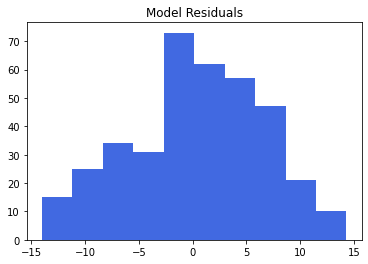

In [23]:
# Grab the residuals & then call the hist() method
(y_test - y_predict).hist(grid = False, color = 'royalblue')
plt.title("Model Residuals")
plt.show()

***
### Plotting our Line
We have this beautiful model, but we cannot see it. Let us create a graph where we have our data and our linear regression line on our graph. We should also highlight some of our key metrics below so we should also add them below.

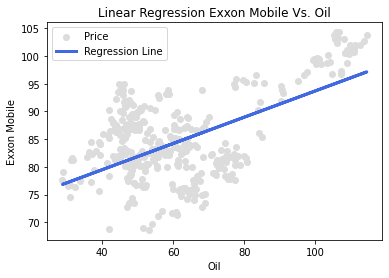

Oil coefficient:0.24
Mean squared error: 38.44
Root Mean squared error: 6.2
R2 score: 0.31


In [25]:
# Plot outputs
plt.scatter(X_test, y_test,  color='gainsboro', label = 'Price')
plt.plot(X_test.values, y_predict, color='royalblue', linewidth = 3, linestyle= '-',label ='Regression Line')

plt.title("Linear Regression Exxon Mobile Vs. Oil")
plt.xlabel("Oil")
plt.ylabel("Exxon Mobile")
plt.legend()
plt.show()

# The coefficients
print('Oil coefficient:' + '\033[1m' + '{:.2}''\033[0m'.format(regression_model.coef_[0][0]))

# The mean squared error
print('Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(model_mse))

# The mean squared error
print('Root Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(math.sqrt(model_mse)))

# Explained variance score: 1 is perfect prediction
print('R2 score: '+ '\033[1m' + '{:.2}''\033[0m'.format(r2_score(y_test,y_predict)))

## Step Six: Save the Model for future use
We will probably want to use this model in the future, so let us save our work so we can use it later. Saving the model can be achieved by storing our model in a pickle which is storing a python object as a character stream in a file which can be reloaded later to use.

In [26]:
import pickle

# pickle the model.
with open('/mnt/artifacts/my_linear_regression.sav','wb') as f:
     pickle.dump(regression_model,f)

# load it back in.
with open('/mnt/artifacts/my_linear_regression.sav', 'rb') as pickle_file:
     regression_model_2 = pickle.load(pickle_file)

# make a new prediction.
regression_model_2.predict([[67.33]])

array([[85.94980965]])